# Graph Analysis   
In this notebook we load the processed tau PET data for ADNI and A4, construct the partial correlation graphs and run the statistical analysis of graph level metrics.

## Imports

In [13]:
import pandas as pd
import networkx as nx
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from functools import partial

import seaborn as sns

plt.style.use("ggplot")

pd.set_option("display.max_columns", 100)

from sklearn.preprocessing import PowerTransformer,StandardScaler
from sklearn.covariance import GraphicalLasso
from sklearn.pipeline import make_pipeline

## Utility functions
The core of the analysis goes like this:

1. Load a table with the regional tau SUVr for a given cohort
2. Estimate the precision matrix using `GraphicalLasso` from scikit-learn
3. Compute the partial correlation matrix from the precision matrix
4. Create a Networkx `Graph` from the partial correlation matrix and compute some graph metrics
5. Bootstrap: resample the table, and repeat steps 1-4 to estimate the confidence interval on the graph metrics.

The functions in this section roughly correspond to the steps just described.

In [14]:
def small_world_coeff(G, niter=1, nrand=10):
    """Compute the small world coefficient of a weighted graph G. Average over `nrand` samples of the randomized graph."""
    Crand = 0
    Lrand = 0

    for _ in range(nrand):
        G_rand = nx.random_reference(G, niter)

        Crand += nx.average_clustering(G_rand, weight="correlation")
        Lrand += nx.average_shortest_path_length(G_rand, weight="distance")

    C = nx.average_clustering(G, weight="correlation")
    L = nx.average_shortest_path_length(G, weight="distance")

    return (C / Crand) / (L / Lrand)


def unweighted_small_world_coeff(G, niter=1, nrand=10):
    """Compute the small world coefficient of a weighted graph. Average over `nrand` samples of the randomized graph."""
    Crand = 0
    Lrand = 0

    for _ in range(nrand):
        G_rand = nx.random_reference(G, niter)

        Crand += nx.average_clustering(G_rand)
        Lrand += nx.average_shortest_path_length(G_rand)

    C = nx.average_clustering(G)
    L = nx.average_shortest_path_length(G)

    return (C / Crand) / (L / Lrand)


def partial_correlation(precision):
    """Compute the partial correlation from a given precision matrix"""

    diag = precision.values.diagonal()

    # The - sign is correct, but the diagonal should have 1 instead of -1,
    # so we fill it explicitly with ones. The formula on wikipedia only applies
    # to off-diagonal elements
    partial_correl = -precision.copy() / np.sqrt(diag[:, None] * diag[None, :])

    np.fill_diagonal(partial_correl.values, 1)

    return partial_correl


def pcorr_to_distance(pcorr):
    """Compute the distance matrix associated to a given partial correlation
    matrix: disconnected nodes should stay disconnected, nodes with high
    correlation should be close to each other. We also drop connections associated with negative weights
    """

    # return (1 / np.abs(pcorr) - 1).replace({np.inf: 0, -np.inf: 0})

    # return (pcorr != 0) * (1 - np.abs(pcorr)) # same as Dyrba 2020, but removing connections set to 0 by lasso

    # As explained in the main text, we use arctanh to convert partial correlations into distances
    if pcorr <= 0:
        return 0
    else:
        return -np.arctanh(np.abs(pcorr) - 1)

    # return 1 - np.abs(pcorr) # this is what Dyrba 2020 uses, it makes fully connected graphs

    # return -np.log(np.abs(pcorr)).replace({np.inf: 0, -np.inf: 0, np.nan:0})


def compute_precision(data, params, return_covariance=False):
    """Takes a dataframe and computes the precision matrix via sklearn.covariance.GraphicalLasso. The data is first transformed via PowerTransformer to ensure normality.

    Arguments:
    data: dataframe
    params: dictionary of paramters passed to GraphicaLasso.
    return_covariance: if True, also return the covariance matrix. By default only return precision
    """

    glasso = make_pipeline(
        # PowerTransformer(), 
        StandardScaler(),
        GraphicalLasso(**params)
        )

    glasso.fit(data)

    if return_covariance:
        labels = glasso.feature_names_in_
        return (
            pd.DataFrame(
                glasso.named_steps["graphicallasso"].precision_,
                index=labels,
                columns=labels,
            ),
            pd.DataFrame(
                glasso.named_steps["graphicallasso"].covariance_,
                index=labels,
                columns=labels,
            ),
        )
    else:
        # GraphicalLasso does not support working natively with dataframes
        # we have to restore the column names by hand
        labels = glasso.feature_names_in_
        return pd.DataFrame(
            glasso.named_steps["graphicallasso"].precision_,
            index=labels,
            columns=labels,
        )


def compute_partial_correlation(data, params):
    """Convenience function to compute the partial correlation matrix from data"""

    return partial_correlation(compute_precision(data, params))


def precision_to_graph(precision):
    """Convert the provided precision matrix into a networkx graph.

    Arguments:
    precision: dataframe, column names will become node labels
    allow_self_connections: bool, if False zero out the diagonal"""

    # Adjacency matrix
    adj = partial_correlation(precision)

    graph = nx.from_pandas_adjacency(adj)

    # we only included age to control for it, we remove it from the graph before computing graph metrics
    graph.remove_node("PTAGE")

    # remove self loops
    graph.remove_edges_from([(u, v) for u, v in graph.edges() if u == v])

    # rename weight to correlation
    nx.set_edge_attributes(
        graph,
        {
            (u, v): {"correlation": d["weight"]}
            for u, v, d in graph.edges(data=True)
        },
    )

    # convenience: absolute value of correlation
    nx.set_edge_attributes(
        graph,
        {
            (u, v): {"abs(correlation)": np.abs(d["weight"])}
            for u, v, d in graph.edges(data=True)
        },
    )

    # compute distances from partial correlations
    nx.set_edge_attributes(
        graph,
        name="distance",
        values={
            (u, v): pcorr_to_distance(weight)
            for u, v, weight in graph.edges(data="weight")
        },
    )

    return graph


def compute_metrics(graph, metrics):
    """Compute graph metrics for a networks graph.

    Arguments:
    graph: networkx graph
    metrics: dictionary of metric names and callables

    Returns:
    res: dictionary of metric names and metric values"""

    return {metric: metrics[metric](graph) for metric in metrics}


def data_to_metrics(data, params, metrics, randomize_graph=False):
    # Convenience function, wrapping all steps into one
    precision = compute_precision(data, params=params)

    if randomize_graph:
        graph = nx.random_reference(precision_to_graph(precision))
    else:
        graph = precision_to_graph(precision)

    return compute_metrics(graph, metrics)


def boostrap_graph_metrics(
    data, params, metrics, n_samples=8, randomize_graph=False
):
    """Resample the datframe data, generate graph and compute metrics. Returns a dataframe with the bootstrapped metrics"""

    bootstrap_samples = [
        data.sample(frac=1, replace=True) for _ in range(n_samples)
    ]

    with multiprocessing.Pool() as pool:
        res = pool.map(
            partial(
                data_to_metrics,
                params=params,
                metrics=metrics,
                randomize_graph=randomize_graph,
            ),
            bootstrap_samples,
        )

    return pd.DataFrame(res)


def bootstrap(data, func, n_samples=8):
    # Resample from data and apply fun to each sample
    # use this version for general functions rather than graph metrics

    bootstrap_samples = [
        data.sample(frac=1, replace=True) for _ in range(n_samples)
    ]

    with multiprocessing.Pool() as pool:
        res = pool.map(func, bootstrap_samples)

    return res

In [15]:
adni = pd.read_csv(
        "../../data_paths_and_cleaning/data/intermediate_data/adni/merged_adni_at_amy_pos_bi_harm.csv",
        dtype={"RID": str},
    )

# Normalize the adni values by cerebellum cortex values for better comparison to A4
adni = pd.concat(
        (
            adni[["RID", "CENTILOIDS"]],
            adni.drop(columns=["RID", "CENTILOIDS"]).div(
                adni["CEREBELLUM_CORTEX"], axis=0
            ),
        ),
        axis=1,
    ).drop(columns="CEREBELLUM_CORTEX")

a4 = pd.read_csv(
        "../../data_paths_and_cleaning/data/intermediate_data/a4/merged_a4_at_amy_pos_bi_harm.csv",
        dtype={"RID": str},
    ).drop(columns="CEREBELLUM_CORTEX")

# The demographics data is in a separate file from the regional tau, we will merge them later

demo_a4 = pd.read_csv(
        "../../data_paths_and_cleaning/data/demographic_csvs/A4/a4_filtered_demo.csv",
        dtype={"RID": str},
    )

demo_adni = pd.read_csv(
        "../../data_paths_and_cleaning/data/demographic_csvs/ADNI/adni_filtered_demo.csv",
        dtype={"RID": str},
    )

demog = pd.concat([demo_adni, demo_a4], keys=["ADNI", "A4"]).reset_index(
        level=0, names="Dataset"
    )


adni_with_demo = pd.merge(adni, demo_adni[["RID", "PTAGE"]], on="RID")
a4_with_demo = pd.merge(a4, demo_a4[["RID", "PTAGE"]], on="RID")

# For the next examples, we use the "high amyloid" group from ADNI
data = adni_with_demo[adni_with_demo["CENTILOIDS"] > 54].drop(
        columns=["RID", "CENTILOIDS"]
    )

## Amyloid quantiles
We split both datasets in tertiles using the ADNI distribution as reference.

In [16]:
n_quantiles = 3

adni_quantile_labels, adni_amy_bins = pd.qcut(
    adni_with_demo["CENTILOIDS"], q=n_quantiles, retbins=True, labels=False
)

adni_amy_bins

a4[
    "CENTILOIDS"
].max()  # this should be less than the adni maximum, which it is

192.541

In [17]:
a4_quantile_labels = pd.cut(a4["CENTILOIDS"], adni_amy_bins, labels=False)


pd.concat(
    (a4_quantile_labels, adni_quantile_labels), keys=("A4", "ADNI")
).reset_index(level=0).rename(
    columns={"level_0": "Dataset", "CENTILOIDS": "Centiloid quantile"}
).value_counts().sort_index()

Dataset  Centiloid quantile
A4       0                     159
         1                     144
         2                      70
ADNI     0                     139
         1                     129
         2                     130
Name: count, dtype: int64

## Example: Visualize one graph
For graphical clarity we use the partial correlation squared as edge thickness, but all metrics are computed using the partial correlation directly.

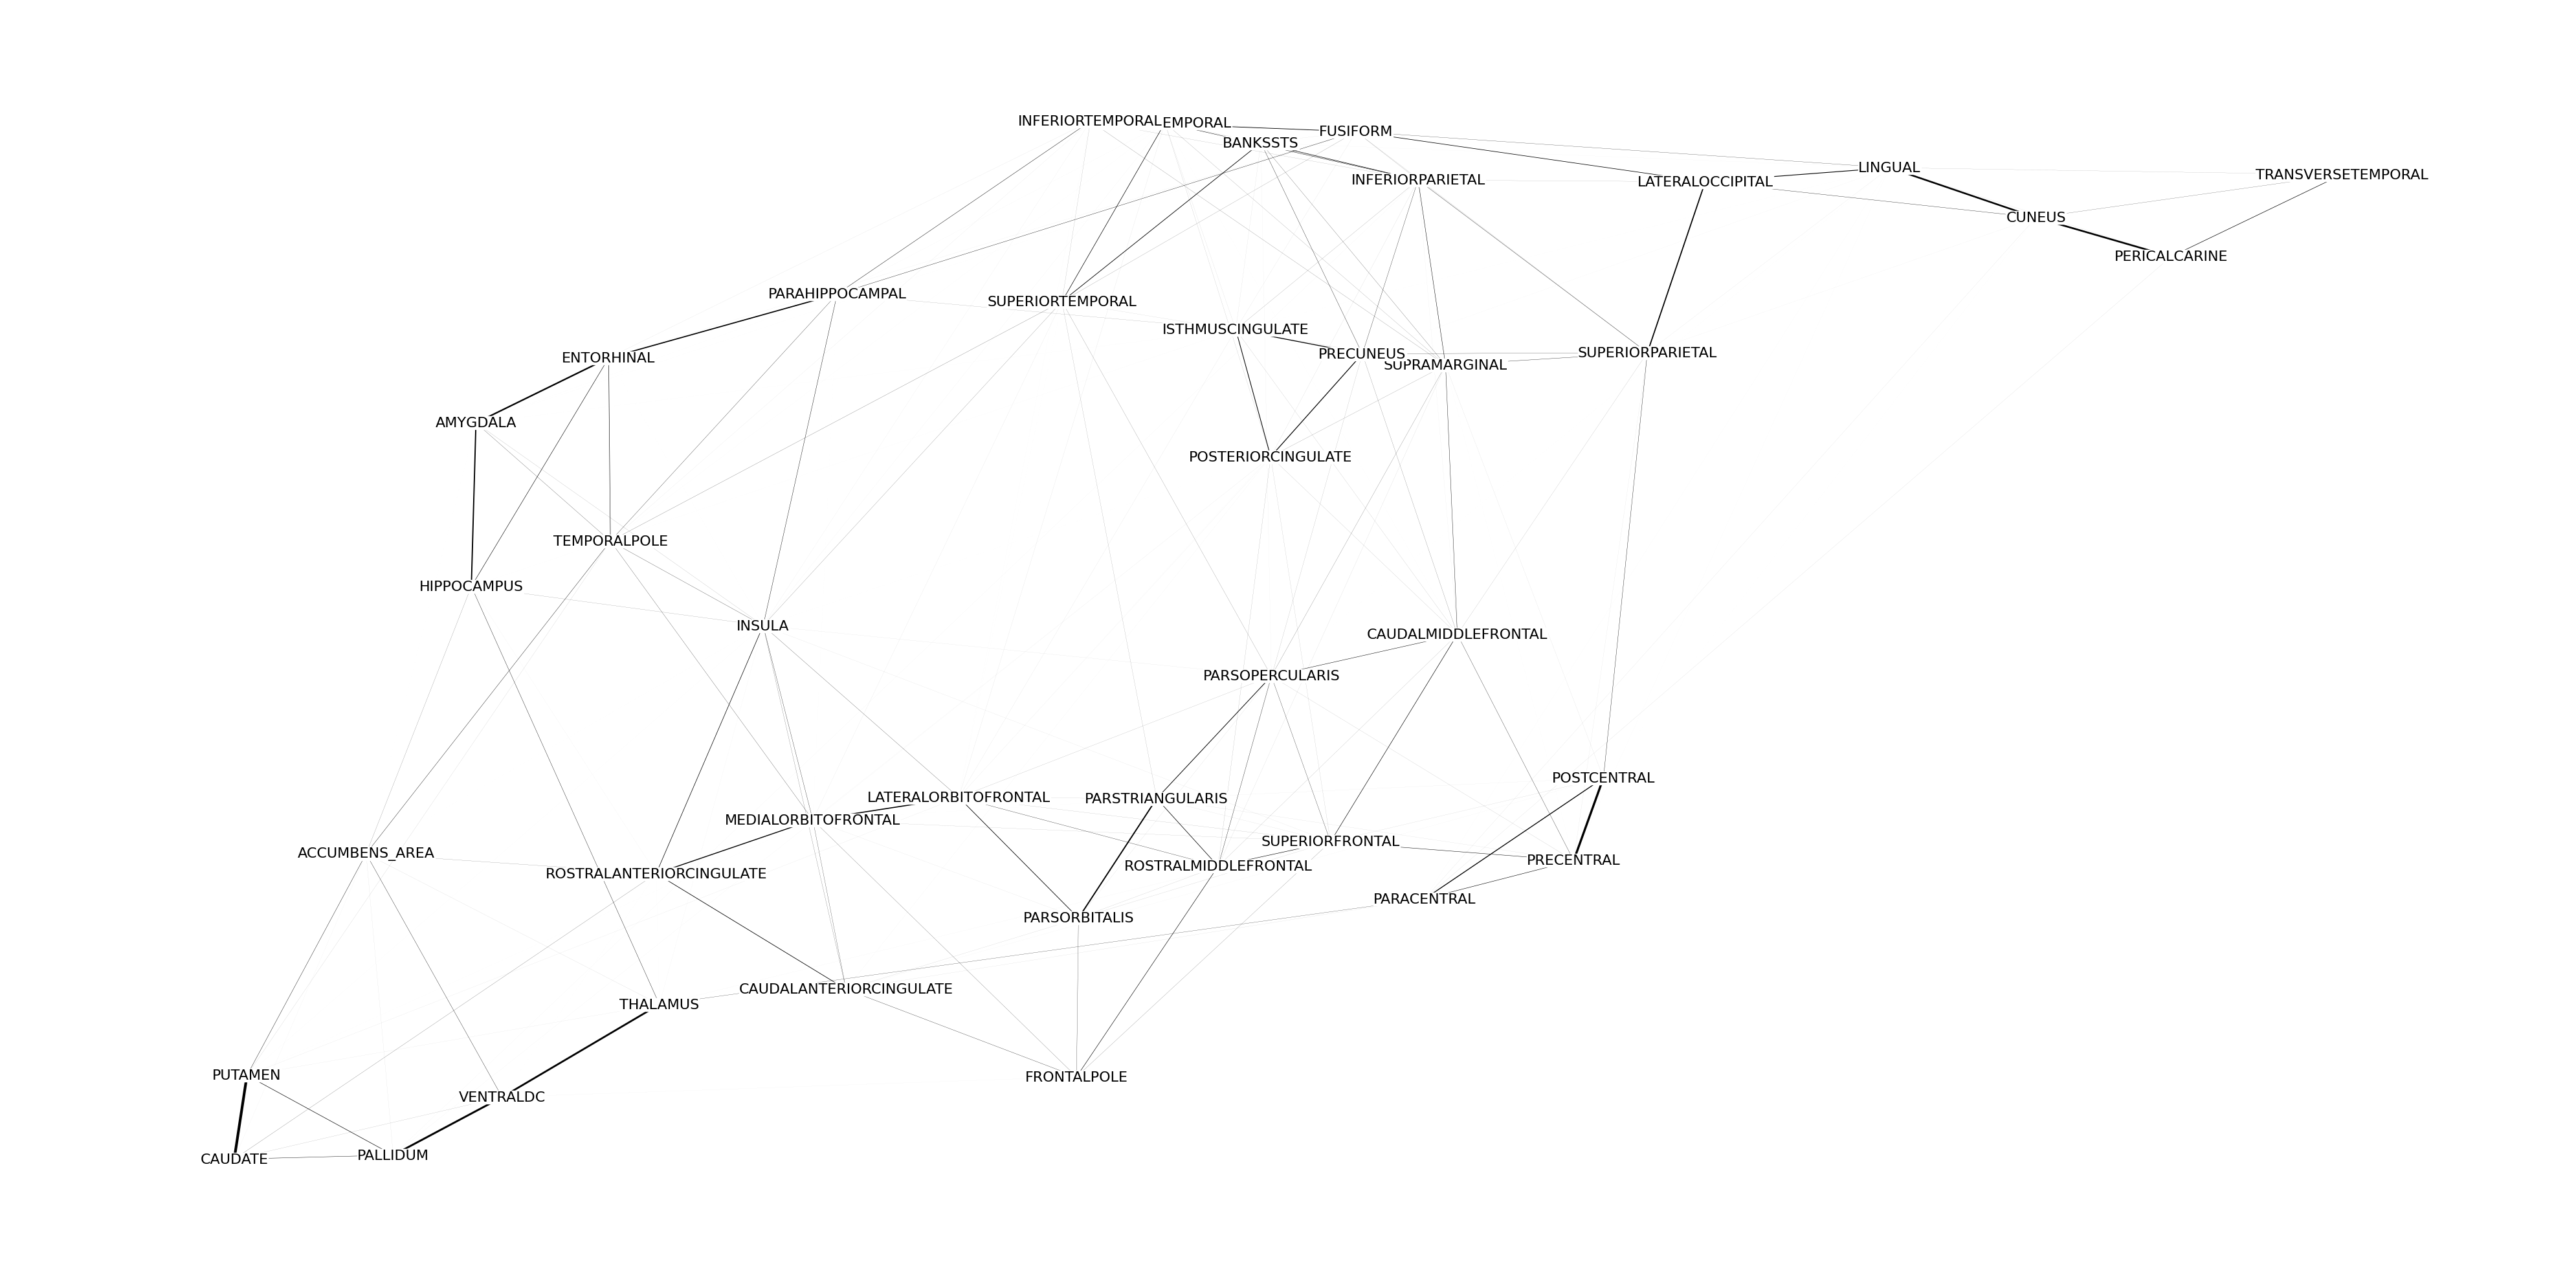

In [18]:
_edge_weights = [
        1.5 * (2.22 * graph[u][v]["abs(correlation)"]) ** 2
        for u, v in graph.edges()
    ]

_fig, _ax = plt.subplots(1, 1, figsize=(20, 10))

nx.set_edge_attributes(
        graph,
        {
            (u, v): {"plot_weight": 0.75 * (2.22 * d["abs(correlation)"]) ** 2}
            for u, v, d in graph.edges(data=True)
        },
    )

pos = nx.spectral_layout(graph, weight="distance")
pos = nx.spring_layout(graph, pos=pos, weight="plot_weight", iterations=100)

nx.draw_networkx_edges(graph, pos, width=_edge_weights, ax=_ax)

nx.draw_networkx_labels(
        graph,
        pos,
        ax=_ax,
        font_size=8,
        bbox=dict(facecolor="white", alpha=1, edgecolor="white", pad=0),
    )

    # Draw edge labels
    # edge_labels = nx.get_edge_attributes(graph, 'correlation')
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.axis("off")
_fig.tight_layout()

# Comparison of graphs

In [19]:
_params = {
    "alpha": 0.15,
    "max_iter": 1000,
    "tol": 1e-3,
    "mode": "cd",
    "eps": 1e-12,
    "enet_tol": 1e-7,
}

precision, covariance = compute_precision(
    data, _params, return_covariance=True
)

pcorr = partial_correlation(precision)

graph = precision_to_graph(precision)

graph_adni_low = precision_to_graph(
    compute_precision(
        adni_with_demo[adni_quantile_labels == 0].drop(
            columns=["RID", "CENTILOIDS"]
        ),
        params=_params,
    )
)

graph_adni_med = precision_to_graph(
    compute_precision(
        adni_with_demo[adni_quantile_labels == 1].drop(
            columns=["RID", "CENTILOIDS"]
        ),
        params=_params,
    )
)

graph_adni_high = precision_to_graph(
    compute_precision(
        adni_with_demo[adni_quantile_labels == 2].drop(
            columns=["RID", "CENTILOIDS"]
        ),
        params=_params,
    )
)

graph_a4_low = precision_to_graph(
    compute_precision(
        a4_with_demo[a4_quantile_labels == 0].drop(
            columns=["RID", "CENTILOIDS"]
        ),
        params=_params,
    )
)

graph_a4_med = precision_to_graph(
    compute_precision(
        a4_with_demo[a4_quantile_labels == 1].drop(
            columns=["RID", "CENTILOIDS"]
        ),
        params=_params,
    )
)

graph_a4_high = precision_to_graph(
    compute_precision(
        a4_with_demo[a4_quantile_labels == 2].drop(
            columns=["RID", "CENTILOIDS"]
        ),
        params=_params,
    )
)

In [20]:
# dictionary of abbreviations used in the figure

abbreviations = {
    "ACCUMBENS_AREA": "Acc",
    "AMYGDALA": "Amg",
    "BANKSSTS": "Bnk",
    "CAUDALANTERIORCINGULATE": "CaACg",
    "CAUDALMIDDLEFRONTAL": "CaMFr",
    "CAUDATE": "Cau",
    "CUNEUS": "Cun",
    "ENTORHINAL": "Ent",
    "FRONTALPOLE": "FrPo",
    "FUSIFORM": "Fus",
    "HIPPOCAMPUS": "Hip",
    "INFERIORPARIETAL": "InPa",
    "INFERIORTEMPORAL": "InTm",
    "INSULA": "Ins",
    "ISTHMUSCINGULATE": "IsCg",
    "LATERALOCCIPITAL": "LtOc",
    "LATERALORBITOFRONTAL": "LtOFr",
    "LINGUAL": "Lin",
    "MEDIALORBITOFRONTAL": "MeOFr",
    "MIDDLETEMPORAL": "MiTm",
    "PALLIDUM": "Pal",
    "PARACENTRAL": "PaCt",
    "PARAHIPPOCAMPAL": "PaHi",
    "PARSOPERCULARIS": "PrsOp",
    "PARSORBITALIS": "PrsOr",
    "PARSTRIANGULARIS": "PrsTr",
    "PERICALCARINE": "PerCa",
    "POSTCENTRAL": "PsCt",
    "POSTERIORCINGULATE": "PstCg",
    "PRECENTRAL": "PreCt",
    "PRECUNEUS": "PreCu",
    "PUTAMEN": "Put",
    "ROSTRALANTERIORCINGULATE": "RsACg",
    "ROSTRALMIDDLEFRONTAL": "RsMFr",
    "SUPERIORFRONTAL": "SuFr",
    "SUPERIORPARIETAL": "SuPr",
    "SUPERIORTEMPORAL": "SuTm",
    "SUPRAMARGINAL": "SuMr",
    "TEMPORALPOLE": "TmPo",
    "THALAMUS": "Th",
    "TRANSVERSETEMPORAL": "TrTm",
    "VENTRALDC": "VnD",
}

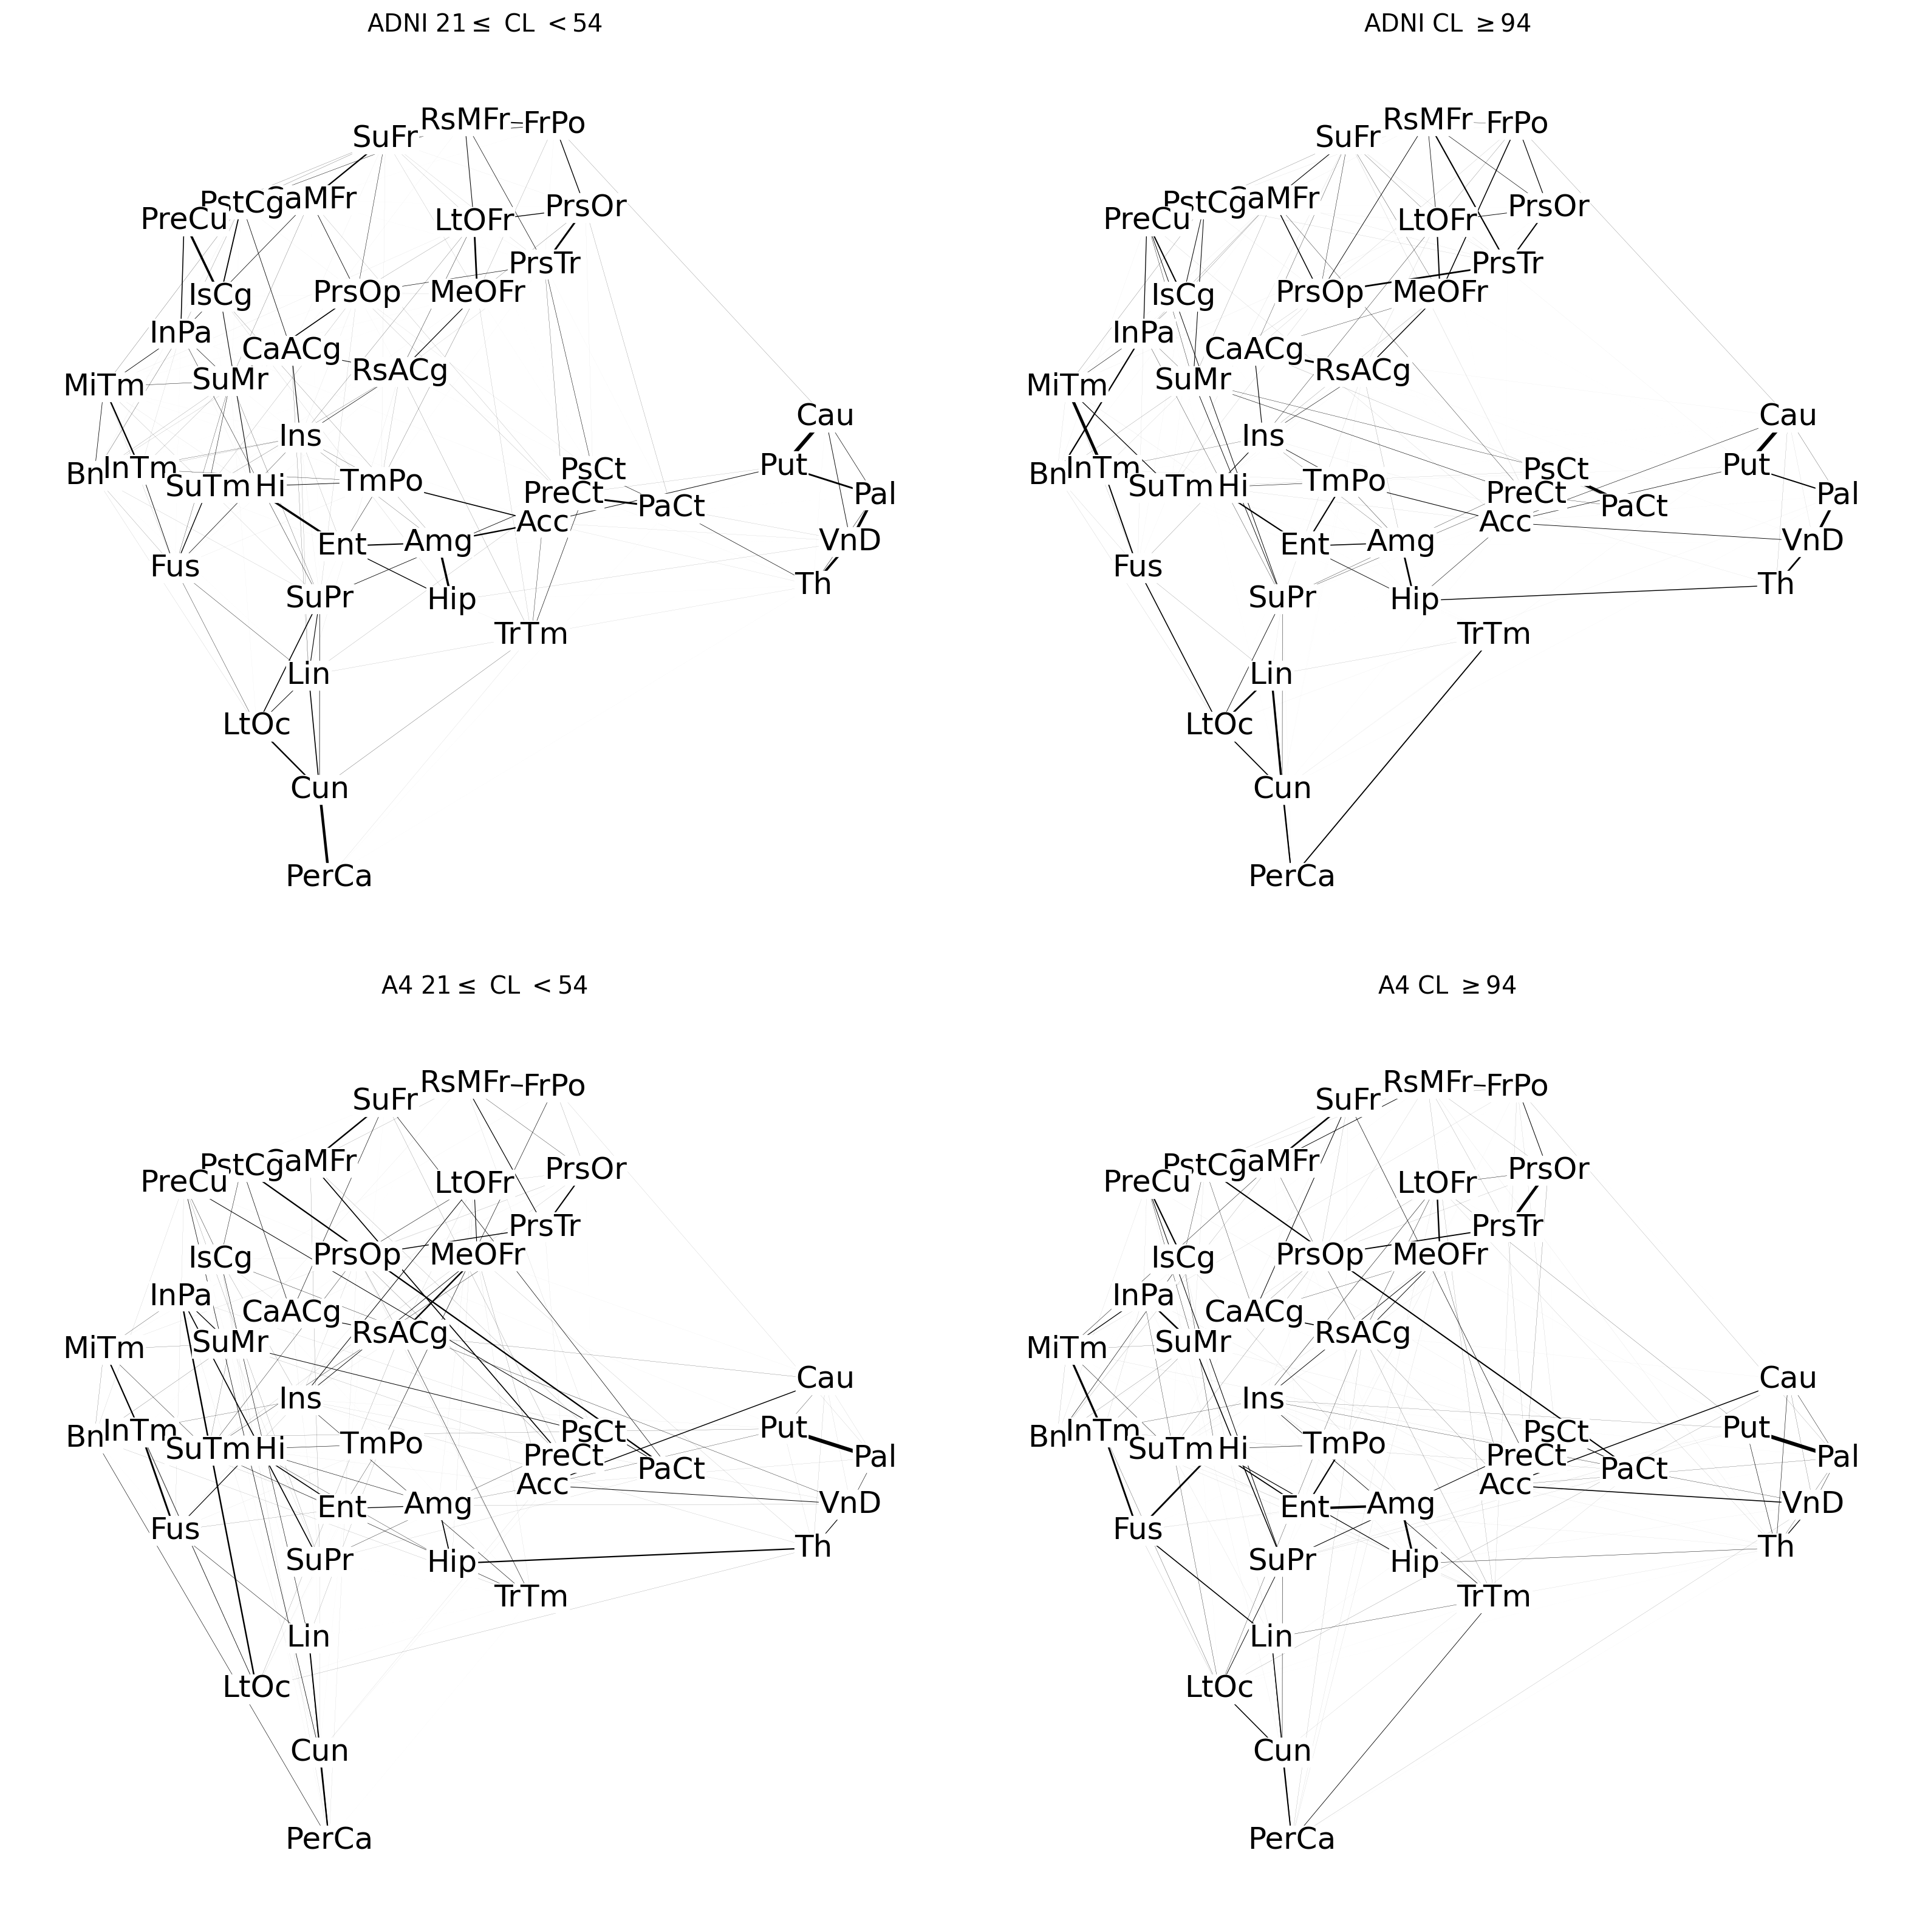

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16), squeeze=False)


def plot_graph(G, pos, ax):
    # this function plots a single graph G, using the positions pos for the nodes, on the matplotlib axes ax
    # the idea is to make a 3x2 plt.subplots and plot in each axes one of the graphs
    # normalize the edge weights so that the largest is 1, and the others are divided by that

    # we normalize the max thickness to the highest weight actually observed in the graph
    max_weight = (
        1
        / np.array(
            list(nx.get_edge_attributes(G, "correlation").values())
        ).max()
    )

    pow = 2 # power to raise the edge weights, to highlight the highest weights

    # for plotting weights
    edge_weights = [
        2.25 * (max_weight * G[u][v]["abs(correlation)"]) ** pow
        for u, v in G.edges()
    ]

    # for computing layout
    nx.set_edge_attributes(
        G,
        {
            (u, v): {
                "plot_weight": 0.75
                * (max_weight * d["abs(correlation)"]) ** pow
            }
            for u, v, d in G.edges(data=True)
        },
    )

    if pos is None:
        # pos = nx.spectral_layout(graph, weight="plot_weight")
        # pos = nx.circular_layout(graph)
        # pos = nx.random_layout(graph)
        pos = nx.kamada_kawai_layout(G, weight="abs(correlation)")
        pos = nx.spring_layout(
            G, pos=pos, weight="plot_weight", iterations=100
        )

    nx.draw_networkx_edges(G, pos, width=edge_weights, ax=ax)

    nx.draw_networkx_labels(
        G,
        pos,
        labels=abbreviations,
        ax=ax,
        font_size=18,
        bbox=dict(facecolor="white", alpha=1, edgecolor="white", pad=0),
    )

    # Draw edge labels
    # edge_labels = nx.get_edge_attributes(graph, 'correlation')
    # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    ax.axis("off")

    return pos


layout_pos = plot_graph(graph_adni_low, pos=None, ax=ax[0, 0])
ax[0, 0].set_title(r"ADNI $21 \leq$ CL $< 54$")

plot_graph(graph_adni_high, pos=layout_pos, ax=ax[0, 1])
ax[0, 1].set_title(r"ADNI CL $\geq 94$")

pos = plot_graph(graph_a4_low, pos=layout_pos, ax=ax[1, 0])
ax[1, 0].set_title(r"A4 $21 \leq$ CL $< 54$")

plot_graph(graph_a4_high, pos=layout_pos, ax=ax[1, 1])
ax[1, 1].set_title(r"A4 CL $\geq 94$")

fig.tight_layout()

# fig.savefig('graph_comparisons.png',dpi=300)

# plt.show()